# Compare training results for different targets and models

We have access to data from our training benchmarks in [`data`](../data/), where we can find different folders for different target quantum Hamiltonians:

1. [tfim](../data/tfim/): 1D Transverse Field Ising Model (spin)
    $$   
    H = 
    \sum_{i=1}^{n-1} J_{i,i+1} Z_{i}Z_{i+1}
    +
    \sum_{i=1}^{n} B_i X_{i}.
    $$
2. [1d_heisenberg](../data/1d_heisenberg/): 1D Heisenberg model (spin)
   $$
    H = 
    \sum_{i=1}^{n-1}(J^{X}_{i,i+1}X_{i}X_{i+1}+J^{Y}_{i,i+1}Y_{i}Y_{i+1}+J^{Z}_{i,i+1}Z_{i}Z_{i+1})
    +
    \sum_{i=1}^{n}B_i Z_{i}.
   $$
3. [1d_hubbard](../data/1d_hubbard/): 1D Hubbard model (fermion) [The system size is chosen so that the number of sites becomes $n$ after fermionic operators are mapped to spin operators via the Jordan-Wigner transformations]
   $$
    H = 
    -\sum_{j=1}^{n/2-1}\sum_{\sigma\in\{\uparrow,\downarrow\}}
    t_{j,j+1}^{\sigma}(\psi_{j,\sigma}^\dag\psi_{j+1,\sigma} + \psi_{j+1,\sigma}^\dag\psi_{j,\sigma})
    +
    \sum_{j=1}^{n/2-1}
    \mu_{j}\left(\psi_{j,\uparrow}^\dag\psi_{j,\uparrow}-\frac{1}{2}\right) 
    \left(\psi_{j,\downarrow}^\dag\psi_{j,\downarrow}-\frac{1}{2}\right).
   $$
4. [2d_hubbard](../data/2d_hubbard/): 2D Hubbard model (fermion) [The integer $n$ is assumed to be divisible by $4$ and equals to or greater than $8$.
The system size is chosen so that the number of sites becomes $n$ after fermionic operators are mapped to spin operators via the Jordan-Wigner transformations]
   $$
    H =
    -\sum_{\sigma\in\{\uparrow,\downarrow\}}
    \big[
    \underbrace{\sum_{j_x=1}^{n/4-1}\sum_{j_y=1,2}
    t_{\boldsymbol{j},\boldsymbol{j}+\boldsymbol{e}_x}^{\sigma}(\psi_{\boldsymbol{j},\sigma}^\dag\psi_{\boldsymbol{j}+\boldsymbol{e}_x,\sigma} + \psi_{\boldsymbol{j}+\boldsymbol{e}_x,\sigma}^\dag\psi_{\boldsymbol{j},\sigma})}_{\text{hoppings in $x$ direction}} 
    \\
    \qquad\qquad+
    \underbrace{\sum_{j_x=1}^{n/4}
    t_{(j_x,1),(j_x,2)}^{\sigma}(\psi_{(j_x,1),\sigma}^\dag\psi_{(j_x,2),\sigma} + \psi_{(j_x,2),\sigma}^\dag\psi_{(j_x,1),\sigma})}_{\text{hoppings in $y$ direction}} 
    \big]
    \\
    +
    \sum_{j_x=1}^{n/4}\sum_{j_y=1,2}
    \mu_{\boldsymbol{j}}\left(\psi_{\boldsymbol{j},\uparrow}^\dag\psi_{\boldsymbol{j},\uparrow}-\frac{1}{2}\right) 
    \left(\psi_{\boldsymbol{j},\downarrow}^\dag\psi_{\boldsymbol{j},\downarrow}-\frac{1}{2}\right),
   $$
   with $\boldsymbol{j}:=(j_x, j_y)$, $\boldsymbol{e}_x:=(1,0)$, and $\boldsymbol{e}_y:=(1,0)$.

## TFIM

In this section we collect results for the 1D Transverse Field Ising Model (TFIM).
We prepare different target Gibbs states with the TFIM Hamiltonian by fixing the couplings and the inverse temperature.

$J_{i,i+1} = J$ and $B_i = B$ for each qubit $i$. 

The inverse temperature $\beta = 1/T$ takes values in ${0.5, 1, 4, 10, 100}$, and the corresponding Gibbs state is 
$$
\eta(\beta) = \frac{e^{-\beta H}}{\mathrm{Tr}[e^{-\beta H}]}
$$

### Model 0: QBM Hamiltonian is the same as the target Hamiltonian

We start by selecting a Quantum Boltzmann Machine model whose Hamiltonian is the same as the target one. In this case there is no model mismatch, that is, the QBM can exactly represent all the Gibbs states of the TFIM.

The definition of our QBM is
$$
\rho_\theta = \frac{e^{H_\theta}}{Z}
$$
where $H_\theta = \theta_0 \sum_{i=1}^{n-1} Z_{i}Z_{i+1} +  \theta_1 \sum_{i=1}^{n} X_{i}$ and $Z=\mathrm{Tr}[e^{H_\theta}]$.

In [1]:
def stringify(p: float):
    return str(p).replace(".", "-")


def get_exp_name(
    target_label,
    target_beta,
    n_qubits,
    model_label,
    epochs,
    learning_rate,
    shot_noise_sigma,
    depolarizing_noise,
):
    return (
        f"t{target_label}_"
        + f"beta{stringify(target_beta)}_"
        + f"q{n_qubits}_"
        + f"qbm{model_label}_"
        + f"e{epochs}_"
        + f"lr{stringify(learning_rate)}_"
        + f"sn{stringify(shot_noise_sigma)}_"
        + f"dn{stringify(depolarizing_noise)}"
    )

In [2]:
import os

output_path = "../data/1d_tfim"

files = os.listdir(f"{output_path}/histories/")
grads = [f for f in files if "Grad" in f]
qre = [f for f in files if "QRE" in f]

Se the parameters of the experiments that we do not want to change:

In [46]:
target_label = 0
target_beta = 1.0
model_label = 0
epochs = 1000
learning_rate = 0.25
shot_noise_sigma = 0.0
depolarizing_noise = 0.0

Let's look at the training history as a function of the number of qubits.
Remember that here we are only learning 2 parameters, and we are plotting the maximum value of the gradients at each iteration of the stochastic gradient descent algorithm.

In [47]:
all_qubits = [4, 6, 8]  # 10 , 12]

In [48]:
import numpy as np

max_grads_hist = []
n = []
for n_qubits in all_qubits:
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    grad_file = f"MaxGrad_{exp_name}.npy"
    if grad_file in files:
        max_grads_hist.append(np.load(f"{output_path}/histories/{grad_file}"))
        print(f"Reading file {grad_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {grad_file}")

Reading file MaxGrad_t0_beta1-0_q4_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q6_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy


n = 4, max grad (first, last): 0.2334169118396141, 9.753901952652688e-07
n = 6, max grad (first, last): 0.2334369221014341, 9.915812800020962e-07
n = 8, max grad (first, last): 0.23343707606005654, 3.354442699070315e-05


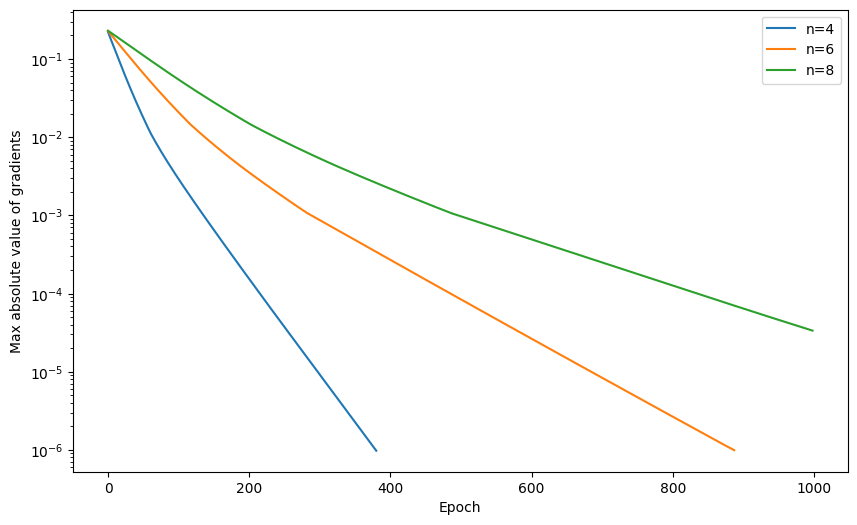

In [68]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in max_grads_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Max absolute value of gradients")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, max_grads_hist):
    print(f"n = {_n}, max grad (first, last): {hist[0]}, {hist[-1]}")

The plot above does not go below `1e-6` because we stop the training when the gradients are smaller than this threshold value. In all effects, we consider that the training has converged. Remember that the loss function landscape is convex and that the minimum is reached when the gradients are zero.

We can make a similar plot for the quantum relative entropy during the training iterations. Since there is no model mismatch (target and model Hamiltonian are the same), we expect that the relative entropy goes to zero at the end of the training.

In [50]:
qre_hist = []
n = []
for n_qubits in all_qubits:
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    qre_file = f"QRE_{exp_name}.npy"
    if qre_file in files:
        qre_hist.append(np.load(f"{output_path}/histories/{qre_file}"))
        print(f"Reading file {qre_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {qre_file}")

Reading file QRE_t0_beta1-0_q4_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q6_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy


n = 4, QRE (first, last): 1.0435128471411441, 0.9615346866066601
n = 6, QRE (first, last): 1.5729418168094087, 1.4358545604343353
n = 8, QRE (first, last): 2.1023707878037374, 1.9101744459289813


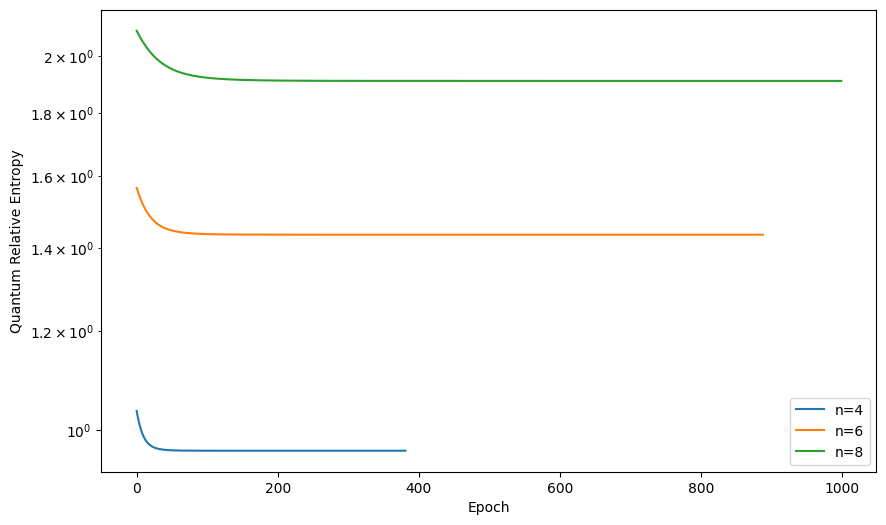

In [69]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in qre_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Quantum Relative Entropy")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, qre_hist):
    print(f"n = {_n}, QRE (first, last): {hist[0]}, {hist[-1]}")

We can also fix the number of qubits and look at the training as a function of the temperature

In [16]:
all_betas = [0.5, 1.0, 2.0, 4.0]
n_qubits = 8

In [17]:
qre_hist = []
b = []
for target_beta in all_betas:
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    qre_file = f"QRE_{exp_name}.npy"
    if qre_file in files:
        qre_hist.append(np.load(f"{output_path}/histories/{qre_file}"))
        print(f"Reading file {qre_file}")
        b.append(target_beta)
    else:
        print(f"Missing file {qre_file}")

Reading file QRE_t0_beta0-5_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file QRE_t0_beta2-0_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy
Reading file QRE_t0_beta4-0_q8_qbm0_e1000_lr0-25_sn0-0_dn0-0.npy


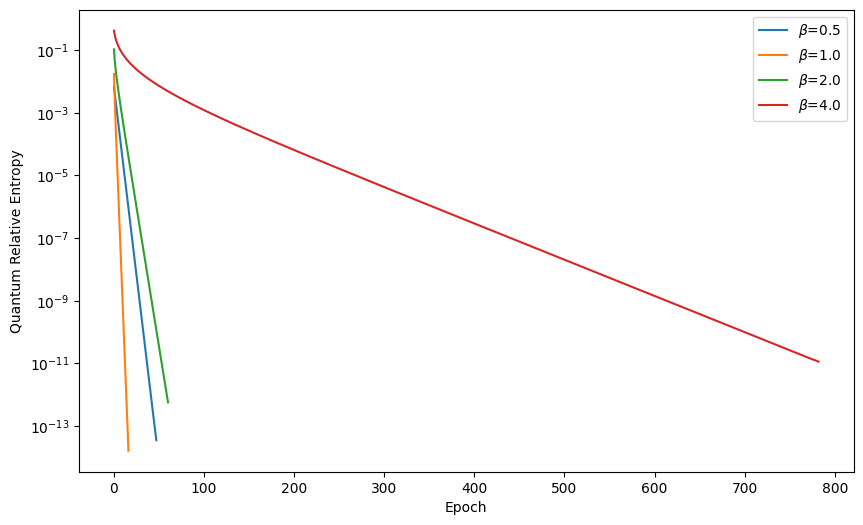

In [18]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in qre_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Quantum Relative Entropy")
ax.set_yscale("log")
ax.legend([rf"$\beta$={_}" for _ in b])

### Model 6: QBM Hamiltonian contains the target Hamiltonian

Next, we select a Quantum Boltzmann Machine model whose Hamiltonian contains the target one. There is no model mismatch again.

The definition of our QBM is
$$
\rho_\theta = \frac{e^{H_\theta}}{Z}
$$
where 
$$
H_\theta = 
\sum_{i=1}^{n-1}(\theta^X_{i,i+1}X_{i}X_{i+1} + \theta^Y_{i,i+1}Y_{i}Y_{i+1} + \theta^Z_{i,i+1}Z_{i}Z_{i+1})
+
\sum_{i=1}^{n}(\theta^X_i X_{i} + \theta^Y_i Y_{i} + \theta^Z_i Z_{i})
$$ 
and $Z=\mathrm{Tr}[e^{H_\theta}]$.

In [52]:
target_label = 0
target_beta = 1.0
model_label = 6
epochs = 1000
shot_noise_sigma = 0.0
depolarizing_noise = 0.0

In [53]:
all_qubits = [4, 6, 8]  # 10 , 12]
learning_rates = [0.04166, 0.01666, 0.00892]

In [54]:
import numpy as np

max_grads_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    grad_file = f"MaxGrad_{exp_name}.npy"
    if grad_file in files:
        max_grads_hist.append(np.load(f"{output_path}/histories/{grad_file}"))
        print(f"Reading file {grad_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {grad_file}")

Reading file MaxGrad_t0_beta1-0_q4_qbm6_e1000_lr0-04166_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q6_qbm6_e1000_lr0-01666_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q8_qbm6_e1000_lr0-00892_sn0-0_dn0-0.npy


n = 4, max grad (first, last): 0.2334169118396141, 9.753901952652688e-07
n = 6, max grad (first, last): 0.2334369221014341, 9.915812800020962e-07
n = 8, max grad (first, last): 0.23343707606005654, 3.354442699070315e-05


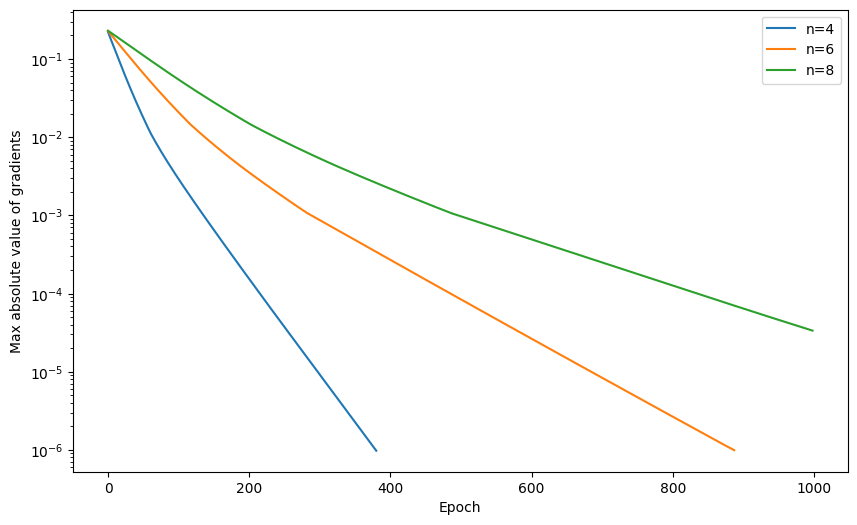

In [70]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in max_grads_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Max absolute value of gradients")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, max_grads_hist):
    print(f"n = {_n}, max grad (first, last): {hist[0]}, {hist[-1]}")

In [38]:
qre_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    qre_file = f"QRE_{exp_name}.npy"
    if qre_file in files:
        qre_hist.append(np.load(f"{output_path}/histories/{qre_file}"))
        print(f"Reading file {qre_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {qre_file}")

Reading file QRE_t0_beta1-0_q4_qbm6_e1000_lr0-04166_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q6_qbm6_e1000_lr0-01666_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q8_qbm6_e1000_lr0-00892_sn0-0_dn0-0.npy


n = 4, QRE (first, last): 1.0435128471411441, 0.9615346866066601
n = 6, QRE (first, last): 1.5729418168094087, 1.4358545604343353
n = 8, QRE (first, last): 2.1023707878037374, 1.9101744459289813


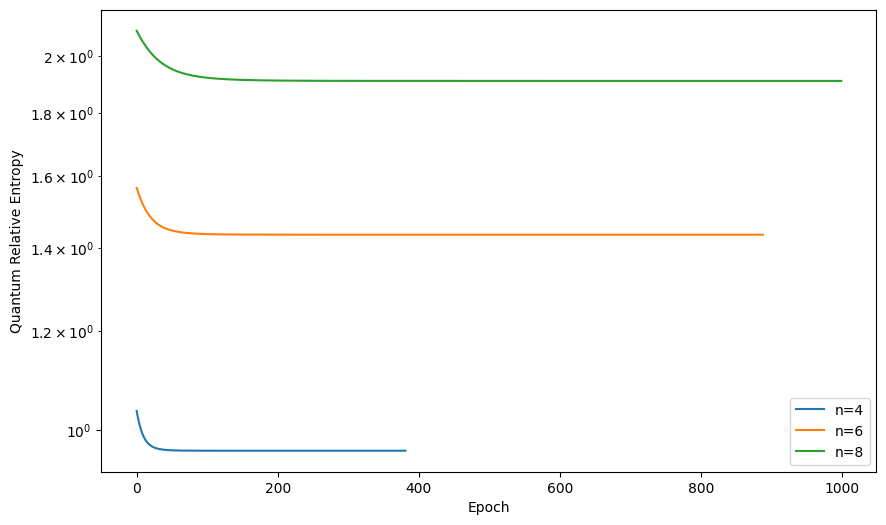

In [71]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in qre_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Quantum Relative Entropy")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, qre_hist):
    print(f"n = {_n}, QRE (first, last): {hist[0]}, {hist[-1]}")

### Model 8: QBM Hamiltonian contains the target Hamiltonian

We move on to the QBM model whose Hamiltonian is
$$
H_\theta = 
\sum_{i,j>i}(\theta^X_{i,j}X_{i}X_{j} + \theta^Y_{i,j}Y_{i}Y_{j} + \theta^Z_{i,j}Z_{i}Z_{j})
+
\sum_{i}(\theta^X_i X_{i} + \theta^Y_i Y_{i} + \theta^Z_i Z_{i})
$$ 
and $Z=\mathrm{Tr}[e^{H_\theta}]$.

In [55]:
target_label = 0
target_beta = 1.0
model_label = 8
epochs = 1000
shot_noise_sigma = 0.0
depolarizing_noise = 0.0

In [56]:
all_qubits = [4, 6, 8]  # 10 , 12]
learning_rates = [0.01667, 0.00794, 0.00463]

In [57]:
import numpy as np

max_grads_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    grad_file = f"MaxGrad_{exp_name}.npy"
    if grad_file in files:
        max_grads_hist.append(np.load(f"{output_path}/histories/{grad_file}"))
        print(f"Reading file {grad_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {grad_file}")

Reading file MaxGrad_t0_beta1-0_q4_qbm8_e1000_lr0-01667_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q6_qbm8_e1000_lr0-00794_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q8_qbm8_e1000_lr0-00463_sn0-0_dn0-0.npy


n = 4, max grad (first, last): 0.2334169118396141, 9.753901952652688e-07
n = 6, max grad (first, last): 0.2334369221014341, 9.915812800020962e-07
n = 8, max grad (first, last): 0.23343707606005654, 3.354442699070315e-05


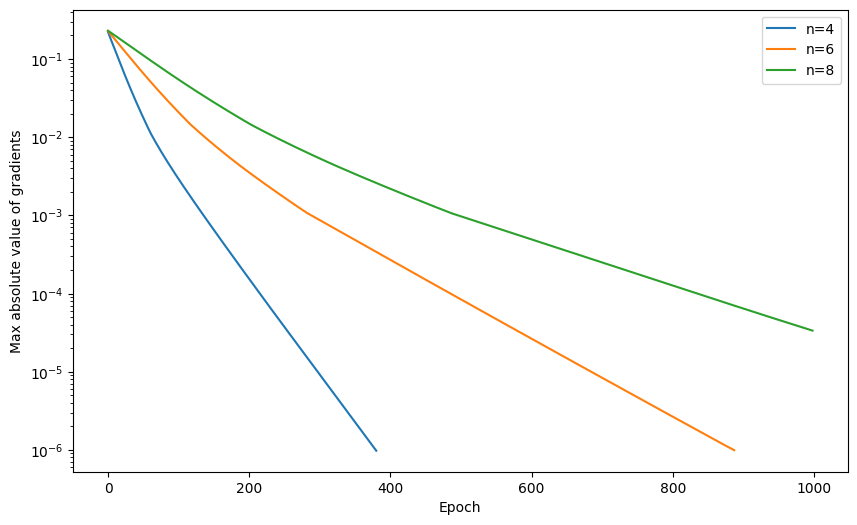

In [72]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in max_grads_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Max absolute value of gradients")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, max_grads_hist):
    print(f"n = {_n}, max grad (first, last): {hist[0]}, {hist[-1]}")

In [59]:
qre_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    qre_file = f"QRE_{exp_name}.npy"
    if qre_file in files:
        qre_hist.append(np.load(f"{output_path}/histories/{qre_file}"))
        print(f"Reading file {qre_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {qre_file}")

Reading file QRE_t0_beta1-0_q4_qbm8_e1000_lr0-01667_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q6_qbm8_e1000_lr0-00794_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q8_qbm8_e1000_lr0-00463_sn0-0_dn0-0.npy


n = 4, QRE (first, last): 1.0435128471411441, 0.9615346866066601
n = 6, QRE (first, last): 1.5729418168094087, 1.4358545604343353
n = 8, QRE (first, last): 2.1023707878037374, 1.9101744459289813


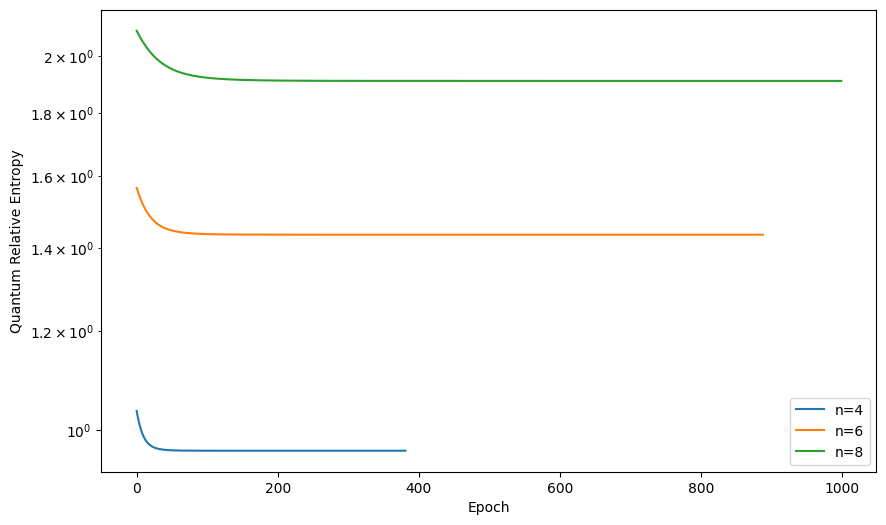

In [73]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in qre_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Quantum Relative Entropy")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, qre_hist):
    print(f"n = {_n}, QRE (first, last): {hist[0]}, {hist[-1]}")

### Model 9: QBM Hamiltonian contains the target Hamiltonian

Finally, we consider the classical BM model whose Hamiltonian is
$$
H_\theta = 
\sum_{i,j>i} \theta_{i,j}Z_{i}Z_{j}
+
\sum_{i}\theta_i Z_{i}
$$ 
and $Z=\mathrm{Tr}[e^{H_\theta}]$.

In [62]:
target_label = 0
target_beta = 1.0
model_label = 9
epochs = 1000
shot_noise_sigma = 0.0
depolarizing_noise = 0.0

In [63]:
all_qubits = [4, 6, 8]  # 10 , 12]
learning_rates = [0.05, 0.02381, 0.01389]

In [64]:
import numpy as np

max_grads_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    grad_file = f"MaxGrad_{exp_name}.npy"
    if grad_file in files:
        max_grads_hist.append(np.load(f"{output_path}/histories/{grad_file}"))
        print(f"Reading file {grad_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {grad_file}")

Reading file MaxGrad_t0_beta1-0_q4_qbm9_e1000_lr0-05_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q6_qbm9_e1000_lr0-02381_sn0-0_dn0-0.npy
Reading file MaxGrad_t0_beta1-0_q8_qbm9_e1000_lr0-01389_sn0-0_dn0-0.npy


n = 4, max grad (first, last): 0.2334169118396141, 9.753901952652688e-07
n = 6, max grad (first, last): 0.2334369221014341, 9.915812800020962e-07
n = 8, max grad (first, last): 0.23343707606005654, 3.354442699070315e-05


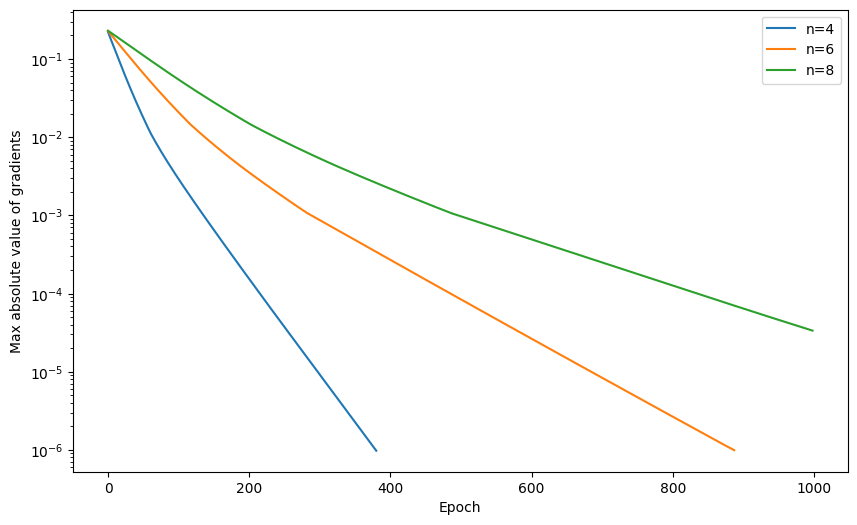

In [74]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in max_grads_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Max absolute value of gradients")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, max_grads_hist):
    print(f"n = {_n}, max grad (first, last): {hist[0]}, {hist[-1]}")

In [66]:
qre_hist = []
n = []
for n_qubits, learning_rate in zip(all_qubits, learning_rates):
    exp_name = get_exp_name(
        target_label,
        target_beta,
        n_qubits,
        model_label,
        epochs,
        learning_rate,
        shot_noise_sigma,
        depolarizing_noise,
    )

    qre_file = f"QRE_{exp_name}.npy"
    if qre_file in files:
        qre_hist.append(np.load(f"{output_path}/histories/{qre_file}"))
        print(f"Reading file {qre_file}")
        n.append(n_qubits)
    else:
        print(f"Missing file {qre_file}")

Reading file QRE_t0_beta1-0_q4_qbm9_e1000_lr0-05_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q6_qbm9_e1000_lr0-02381_sn0-0_dn0-0.npy
Reading file QRE_t0_beta1-0_q8_qbm9_e1000_lr0-01389_sn0-0_dn0-0.npy


n = 4, QRE (first, last): 1.0435128471411441, 0.9615346866066601
n = 6, QRE (first, last): 1.5729418168094087, 1.4358545604343353
n = 8, QRE (first, last): 2.1023707878037374, 1.9101744459289813


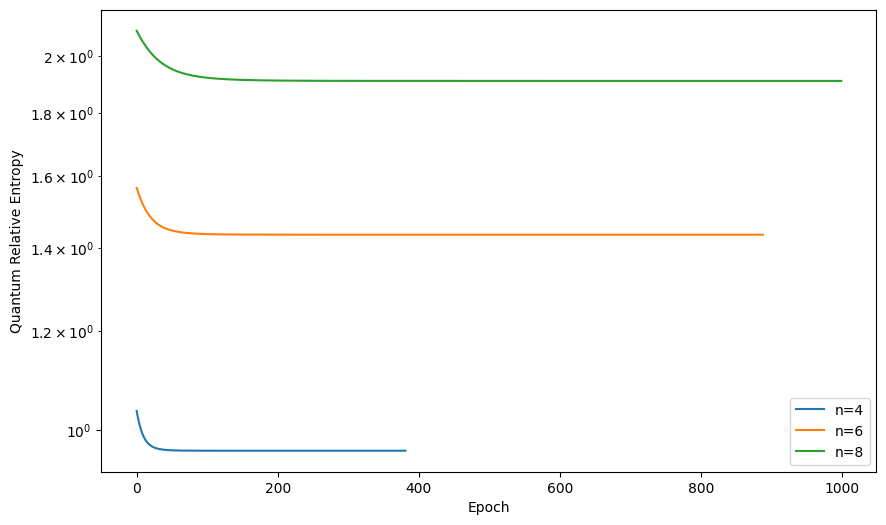

In [75]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
for hist in qre_hist:
    ax.plot(hist[1:], "-")
ax.set_xlabel("Epoch")
ax.set_ylabel("Quantum Relative Entropy")
ax.set_yscale("log")
ax.legend([f"n={_}" for _ in n])

for _n, hist in zip(n, qre_hist):
    print(f"n = {_n}, QRE (first, last): {hist[0]}, {hist[-1]}")